In [36]:
import tensorflow as tf

# GPUデバイスを指定
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # GPUメモリの成長を許可する
        tf.config.experimental.set_memory_growth(gpus[0], True)
        # TensorFlowに特定のGPUを使用するように指示
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    except RuntimeError as e:
        # プログラム起動時にメモリ成長を設定する必要がある
        print(e)

Physical devices cannot be modified after being initialized


In [37]:
import tensorflow as tf
print(tf.__version__)

2.15.0


In [38]:
# 他の必要なインポート
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import matplotlib.pyplot as plt
from imutils import paths
from tqdm import tqdm
import numpy as np
import cv2

# Random seed fixation
tf.random.set_seed(666)
np.random.seed(666)

In [39]:
# How many training images for SimCLR?
train_images = list(paths.list_images("/workspaces/2023f_ojus/SimCLR/boar_data_pre"))
print(len(train_images))

3823


In [40]:
class CustomAugment(object):
    def __call__(self, sample):
        # Random flips
        sample = self._random_apply(tf.image.flip_left_right, sample, p=0.5)

        # Randomly apply transformation (color distortions) with probability p.
        sample = self._random_apply(self._color_jitter, sample, p=0.8)
        sample = self._random_apply(self._color_drop, sample, p=0.2)

        return sample

    def _color_jitter(self, x, s=1):
        # one can also shuffle the order of following augmentations
        # each time they are applied.
        x = tf.image.random_brightness(x, max_delta=0.8*s)
        x = tf.image.random_contrast(x, lower=1-0.8*s, upper=1+0.8*s)
        x = tf.image.random_saturation(x, lower=1-0.8*s, upper=1+0.8*s)
        x = tf.image.random_hue(x, max_delta=0.2*s)
        x = tf.clip_by_value(x, 0, 1)
        return x

    def _color_drop(self, x):
        x = tf.image.rgb_to_grayscale(x)
        x = tf.tile(x, [1, 1, 1, 3])
        return x

    def _random_apply(self, func, x, p):
        return tf.cond(
          tf.less(tf.random.uniform([], minval=0, maxval=1, dtype=tf.float32),
                  tf.cast(p, tf.float32)),
          lambda: func(x),
          lambda: x)

In [41]:
# Build the augmentation pipeline
data_augmentation = Sequential([Lambda(CustomAugment())])

In [42]:
# Image preprocessing utils
@tf.function
def parse_images(image_path):
    image_string = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, size=[224, 224])

    return image

In [43]:
# Create TensorFlow dataset 元は64
BATCH_SIZE = 32

train_ds = tf.data.Dataset.from_tensor_slices(train_images)
train_ds = (
    train_ds
    .map(parse_images, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .shuffle(1024)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

In [44]:
# Architecture utils
def get_resnet_simclr(hidden_1, hidden_2, hidden_3):
    base_model = tf.keras.applications.ResNet50(include_top=False, weights=None, input_shape=(224, 224, 3))
    base_model.trainable = True
    inputs = Input((224, 224, 3))
    h = base_model(inputs, training=True)
    h = GlobalAveragePooling2D()(h)

    projection_1 = Dense(hidden_1)(h)
    projection_1 = Activation("relu")(projection_1)
    projection_2 = Dense(hidden_2)(projection_1)
    projection_2 = Activation("relu")(projection_2)
    projection_3 = Dense(hidden_3)(projection_2)

    resnet_simclr = Model(inputs, projection_3)

    return resnet_simclr

In [45]:
from losses import _dot_simililarity_dim1 as sim_func_dim1, _dot_simililarity_dim2 as sim_func_dim2
import helpers

In [46]:
# Mask to remove positive examples from the batch of negative samples
negative_mask = helpers.get_negative_mask(BATCH_SIZE)

In [47]:
@tf.function
def train_step(xis, xjs, model, optimizer, criterion, temperature):
    with tf.GradientTape() as tape:
        zis = model(xis)
        zjs = model(xjs)

        # normalize projection feature vectors
        zis = tf.math.l2_normalize(zis, axis=1)
        zjs = tf.math.l2_normalize(zjs, axis=1)

        l_pos = sim_func_dim1(zis, zjs)
        l_pos = tf.reshape(l_pos, (BATCH_SIZE, 1))
        l_pos /= temperature

        negatives = tf.concat([zjs, zis], axis=0)

        loss = 0

        for positives in [zis, zjs]:
            l_neg = sim_func_dim2(positives, negatives)

            labels = tf.zeros(BATCH_SIZE, dtype=tf.int32)

            l_neg = tf.boolean_mask(l_neg, negative_mask)
            l_neg = tf.reshape(l_neg, (BATCH_SIZE, -1))
            l_neg /= temperature

            logits = tf.concat([l_pos, l_neg], axis=1)
            loss += criterion(y_pred=logits, y_true=labels)

        loss = loss / (2 * BATCH_SIZE)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss

In [48]:
# train_simclr 関数を変更
def train_simclr(model, dataset, optimizer, criterion, temperature=0.1, epochs=100):
    epoch_wise_loss = []

    for epoch in tqdm(range(epochs)):
        step_wise_loss = []
        for image_batch in dataset:
            a = data_augmentation(image_batch)
            b = data_augmentation(image_batch)

            loss = train_step(a, b, model, optimizer, criterion, temperature)
            step_wise_loss.append(loss.numpy())

        epoch_loss = np.mean(step_wise_loss)
        epoch_wise_loss.append(epoch_loss)
        if epoch % 10 == 0:
            print("epoch: {} loss: {:.3f}".format(epoch + 1, epoch_loss))

    return epoch_wise_loss, model

In [49]:
# GPU情報の確認
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Jan 20 22:17:08 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.146.02             Driver Version: 535.146.02   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080 Ti     Off | 00000000:19:00.0 Off |                  N/A |
| 24%   32C    P8              16W / 250W |  10663MiB / 11264MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [18]:
!nvidia-smi

Sat Jan 20 20:57:18 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.146.02             Driver Version: 535.146.02   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080 Ti     Off | 00000000:19:00.0 Off |                  N/A |
| 24%   28C    P8              14W / 250W |      3MiB / 11264MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [33]:
import torch
print(torch.__version__)

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.ones(1, device=device))

2.1.1
cuda:1
tensor([1.], device='cuda:1')


In [34]:
print("利用可能なGPUの数:", torch.cuda.device_count())
for i in range(torch.cuda.device_count()):
    print(f"cuda:{i}", torch.cuda.get_device_properties(i))


利用可能なGPUの数: 4
cuda:0 _CudaDeviceProperties(name='NVIDIA GeForce RTX 2080 Ti', major=7, minor=5, total_memory=11011MB, multi_processor_count=68)
cuda:1 _CudaDeviceProperties(name='NVIDIA GeForce RTX 2080 Ti', major=7, minor=5, total_memory=11011MB, multi_processor_count=68)
cuda:2 _CudaDeviceProperties(name='NVIDIA GeForce RTX 2080 Ti', major=7, minor=5, total_memory=11011MB, multi_processor_count=68)
cuda:3 _CudaDeviceProperties(name='NVIDIA GeForce RTX 2080 Ti', major=7, minor=5, total_memory=11009MB, multi_processor_count=68)


  1%|          | 1/100 [01:02<1:43:15, 62.58s/it]

epoch: 1 loss: 3.814


 11%|█         | 11/100 [06:55<52:25, 35.34s/it] 

epoch: 11 loss: 1.543


 21%|██        | 21/100 [12:44<45:58, 34.91s/it]

epoch: 21 loss: 1.490


 31%|███       | 31/100 [18:34<40:11, 34.95s/it]

epoch: 31 loss: 1.400


 41%|████      | 41/100 [24:25<34:31, 35.10s/it]

epoch: 41 loss: 1.605


 51%|█████     | 51/100 [30:14<28:32, 34.95s/it]

epoch: 51 loss: 1.568


 61%|██████    | 61/100 [36:03<22:39, 34.85s/it]

epoch: 61 loss: 1.260


 71%|███████   | 71/100 [41:51<16:50, 34.83s/it]

epoch: 71 loss: 1.469


 81%|████████  | 81/100 [47:40<11:02, 34.89s/it]

epoch: 81 loss: 1.641


 91%|█████████ | 91/100 [53:29<05:13, 34.79s/it]

epoch: 91 loss: 1.554


100%|██████████| 100/100 [58:42<00:00, 35.23s/it]


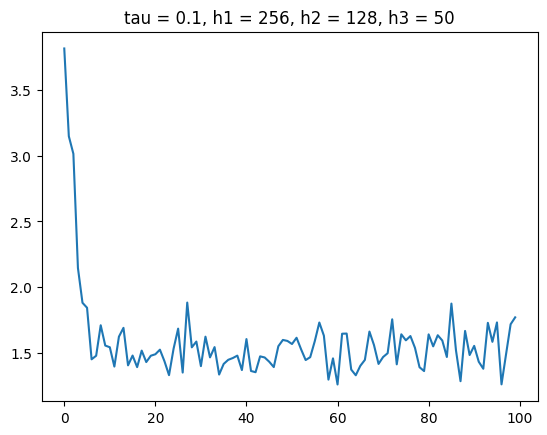

In [50]:
criterion = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                                          reduction=tf.keras.losses.Reduction.SUM)
decay_steps = 1000
lr_decayed_fn = tf.keras.experimental.CosineDecay(
    initial_learning_rate=0.1, decay_steps=decay_steps)
optimizer = tf.keras.optimizers.SGD(lr_decayed_fn)

resnet_simclr_2 = get_resnet_simclr(256, 128, 50)

epoch_wise_loss, resnet_simclr  = train_simclr(resnet_simclr_2, train_ds, optimizer, criterion, temperature=0.1, epochs=100)


plt.plot(epoch_wise_loss)
plt.title("tau = 0.1, h1 = 256, h2 = 128, h3 = 50")
plt.show()

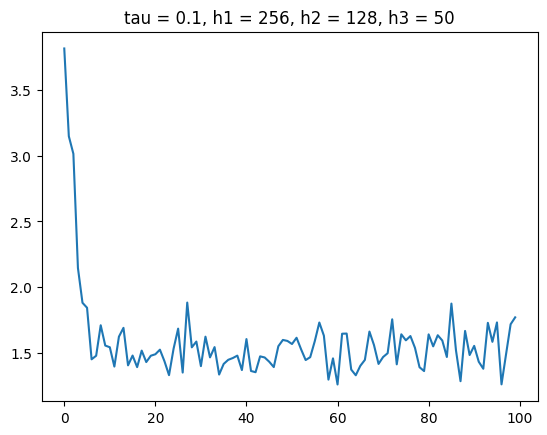

In [51]:
# プロット表示
plt.plot(epoch_wise_loss)
plt.title("tau = 0.1, h1 = 256, h2 = 128, h3 = 50")
plt.show()

# モデルの保存（WandBやGoogle Colab関連のコードは削除されました）
filename = "resnet_simclr_2.h5"
resnet_simclr.save_weights(filename)